<a href="https://colab.research.google.com/github/axelengelmann/datascience_portfolio_axelengelmann/blob/main/Salifort_Motors_project_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Understand the business scenario and problem**

The HR department at Salifort Motors wants to take some initiatives to improve employee satisfaction levels at the company. They collected data from employees, but now they don’t know what to do with it. They refer to you as a data analytics professional and ask you to provide data-driven suggestions based on your understanding of the data. They have the following question: what’s likely to make the employee leave the company?

Your goals in this project are to analyze the data collected by the HR department and to build a model that predicts whether or not an employee will leave the company.

If you can predict employees likely to quit, it might be possible to identify factors that contribute to their leaving. Because it is time-consuming and expensive to find, interview, and hire new employees, increasing employee retention will be beneficial to the company.

* Import packages
* Load dataset

In [4]:

import numpy as np
import pandas as pd


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', None)

from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree


import pickle

In [5]:

df0 = pd.read_csv("/content/HR_comma_sep.csv")
df0.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years Department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

**Data Exploration (Initial EDA and data cleaning)**
* Understand variables
* Clean dataset (missing data, redundant data, outliers)

In [6]:
df0.info()
df0.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


satisfaction_level  last_evaluation  number_project  \
count        14999.000000     14999.000000    14999.000000   
mean             0.612834         0.716102        3.803054   
std              0.248631         0.171169        1.232592   
min              0.090000         0.360000        2.000000   
25%              0.440000         0.560000        3.000000   
50%              0.640000         0.720000        4.000000   
75%              0.820000         0.870000        5.000000   
max              1.000000         1.000000        7.000000   

       average_montly_hours  time_spend_company  Work_accident          left  \
count          14999.000000        14999.000000   14999.000000  14999.000000   
mean             201.050337            3.498233       0.144610      0.238083   
std               49.943099            1.460136       0.351719      0.425924   
min               96.000000            2.000000       0.000000      0.000000   
25%              156.000000            3.000000       0.000000      0.000000   
50%              200.000000            3.000000       0.000000      0.000000   
75%              245.000000            4.000000       0.000000      0.000000   
max              310.000000           10.000000       1.000000      1.000000   

       promotion_last_5years  
count           14999.000000  
mean                0.021268  
std                 0.144281  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 0.000000  
max                 1.000000

Rename columns

In [7]:
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [8]:
df0 = df0.rename(columns={'Work_accident': 'work_accident',
                          'average_montly_hours': 'average_monthly_hours',
                          'time_spend_company': 'tenure',
                          'Department': 'department'})
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

Check missing values

In [9]:
df0.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

Check duplicates

In [10]:
df0.duplicated().sum()

3008

In [11]:
df0[df0.duplicated()].head()


satisfaction_level  last_evaluation  number_project  \
396                 0.46             0.57               2   
866                 0.41             0.46               2   
1317                0.37             0.51               2   
1368                0.41             0.52               2   
1461                0.42             0.53               2   

      average_monthly_hours  tenure  work_accident  left  \
396                     139       3              0     1   
866                     128       3              0     1   
1317                    127       3              0     1   
1368                    132       3              0     1   
1461                    142       3              0     1   

      promotion_last_5years  department  salary  
396                       0       sales     low  
866                       0  accounting     low  
1317                      0       sales  medium  
1368                      0       RandD     low  
1461                      0       sales     low

In [12]:
df1 = df0.drop_duplicates(keep='first')

In [13]:
df1.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  left  promotion_last_5years department  salary  
0       3              0     1                      0      sales     low  
1       6              0     1                      0      sales  medium  
2       4              0     1                      0      sales  medium  
3       5              0     1                      0      sales     low  
4       3              0     1                      0      sales     low

Check outliers

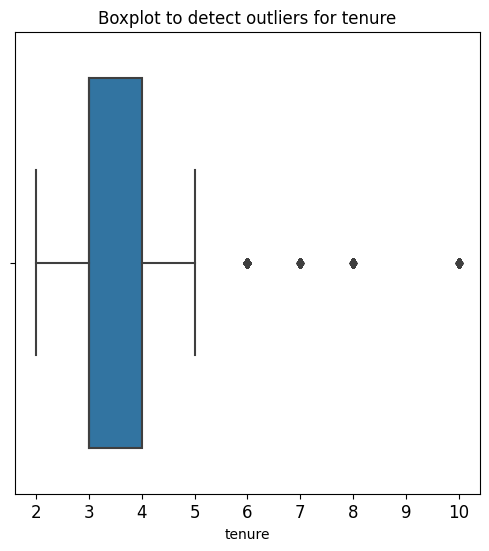

In [14]:
plt.figure(figsize=(6,6))
plt.title('Boxplot to detect outliers for tenure', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df1['tenure'])
plt.show()

In [15]:

# Compute the 25th percentile value in `tenure`
percentile25 = df1['tenure'].quantile(0.25)

# Compute the 75th percentile value in `tenure`
percentile75 = df1['tenure'].quantile(0.75)

# Compute the interquartile range in `tenure`
iqr = percentile75 - percentile25

# Define the upper limit and lower limit for non-outlier values in `tenure`
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

# Identify subset of data containing outliers in `tenure`
outliers = df1[(df1['tenure'] > upper_limit) | (df1['tenure'] < lower_limit)]

# Count how many rows in the data contain outliers in `tenure`
print("Number of rows in the data containing outliers in `tenure`:", len(outliers))

Lower limit: 1.5
Upper limit: 5.5
Number of rows in the data containing outliers in `tenure`: 824


Data visualizations

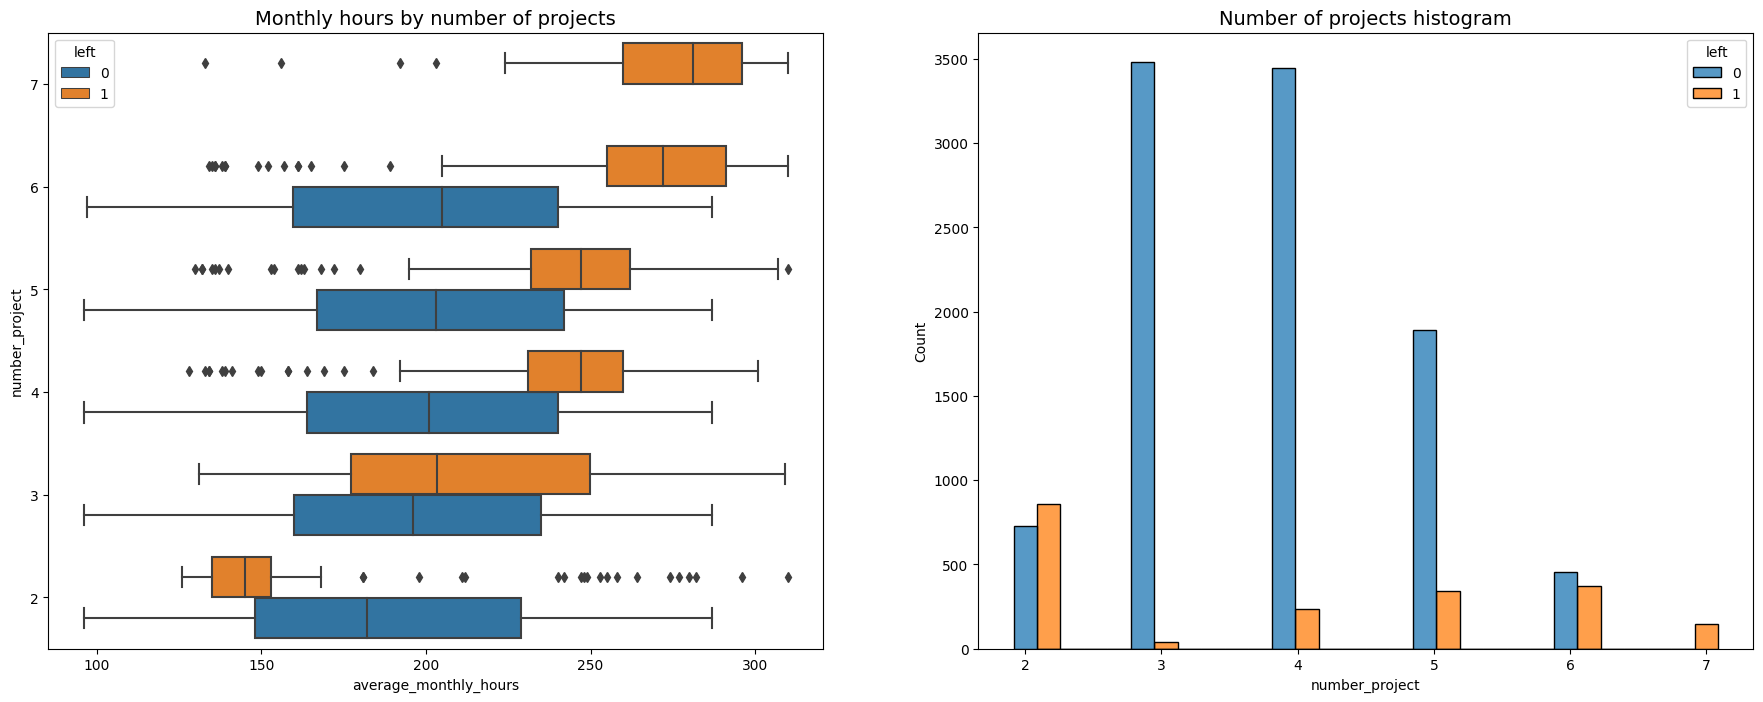

In [16]:

fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Boxplot showing `average_monthly_hours` distributions for `number_project`, comparing employees who stayed versus those who left
sns.boxplot(data=df1, x='average_monthly_hours', y='number_project', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Monthly hours by number of projects', fontsize='14')

# histogram showing distribution of `number_project`, comparing employees who stayed versus those who left
tenure_stay = df1[df1['left']==0]['number_project']
tenure_left = df1[df1['left']==1]['number_project']
sns.histplot(data=df1, x='number_project', hue='left', multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Number of projects histogram', fontsize='14')

# Display the plots
plt.show()

It might be natural that people who work on more projects would also work longer hours. This appears to be the case here, with the mean hours of each group (stayed and left) increasing with number of projects worked. However, a few things stand out from this plot.

There are two groups of employees who left the company: (A) those who worked considerably less than their peers with the same number of projects, and (B) those who worked much more. Of those in group A, it's possible that they were fired. It's also possible that this group includes employees who had already given their notice and were assigned fewer hours because they were already on their way out the door. For those in group B, it's reasonable to infer that they probably quit. The folks in group B likely contributed a lot to the projects they worked in; they might have been the largest contributors to their projects.

Everyone with seven projects left the company, and the interquartile ranges of this group and those who left with six projects was ~255–295 hours/week—much more than any other group.

The optimal number of projects for employees to work on seems to be 3–4. The ratio of left/stayed is very small for these cohorts.

If we assume a work week of 40 hours and two weeks of vacation per year, then the average number of working hours per month of employees working Monday–Friday = 50 weeks * 40 hours per week / 12 months = 166.67 hours per month. This means that, aside from the employees who worked on two projects, every group—even those who didn't leave the company—worked considerably more hours than this. It seems that employees here are overworked.

As the next step, we could confirm that all employees with seven projects left.

In [17]:
#  value counts of stayed/left for employees with 7 projects
df1[df1['number_project']==7]['left'].value_counts()

1    145
Name: left, dtype: int64

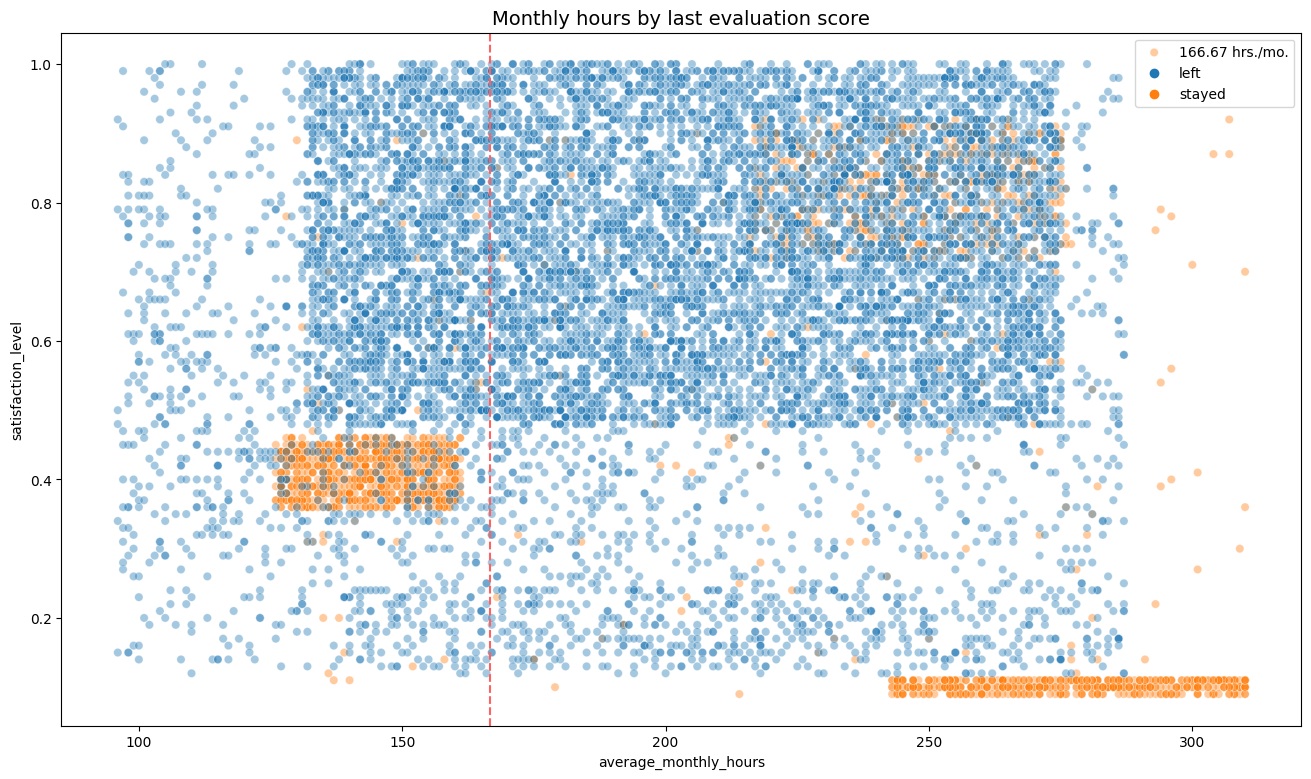

In [18]:
#scatterplot of `average_monthly_hours` versus `satisfaction_level`, comparing employees who stayed versus those who left
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df1, x='average_monthly_hours', y='satisfaction_level', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14');

The scatterplot above shows that there was a sizeable group of employees who worked ~240–315 hours per month. 315 hours per month is over 75 hours per week for a whole year. It's likely this is related to their satisfaction levels being close to zero.

The plot also shows another group of people who left, those who had more normal working hours. Even so, their satisfaction was only around 0.4. It's difficult to speculate about why they might have left. It's possible they felt pressured to work more, considering so many of their peers worked more. And that pressure could have lowered their satisfaction levels.

Finally, there is a group who worked ~210–280 hours per month, and they had satisfaction levels ranging ~0.7–0.9.

Note the strange shape of the distributions here. This is indicative of data manipulation or synthetic data.

For the next visualization, it might be interesting to visualize satisfaction levels by tenure.

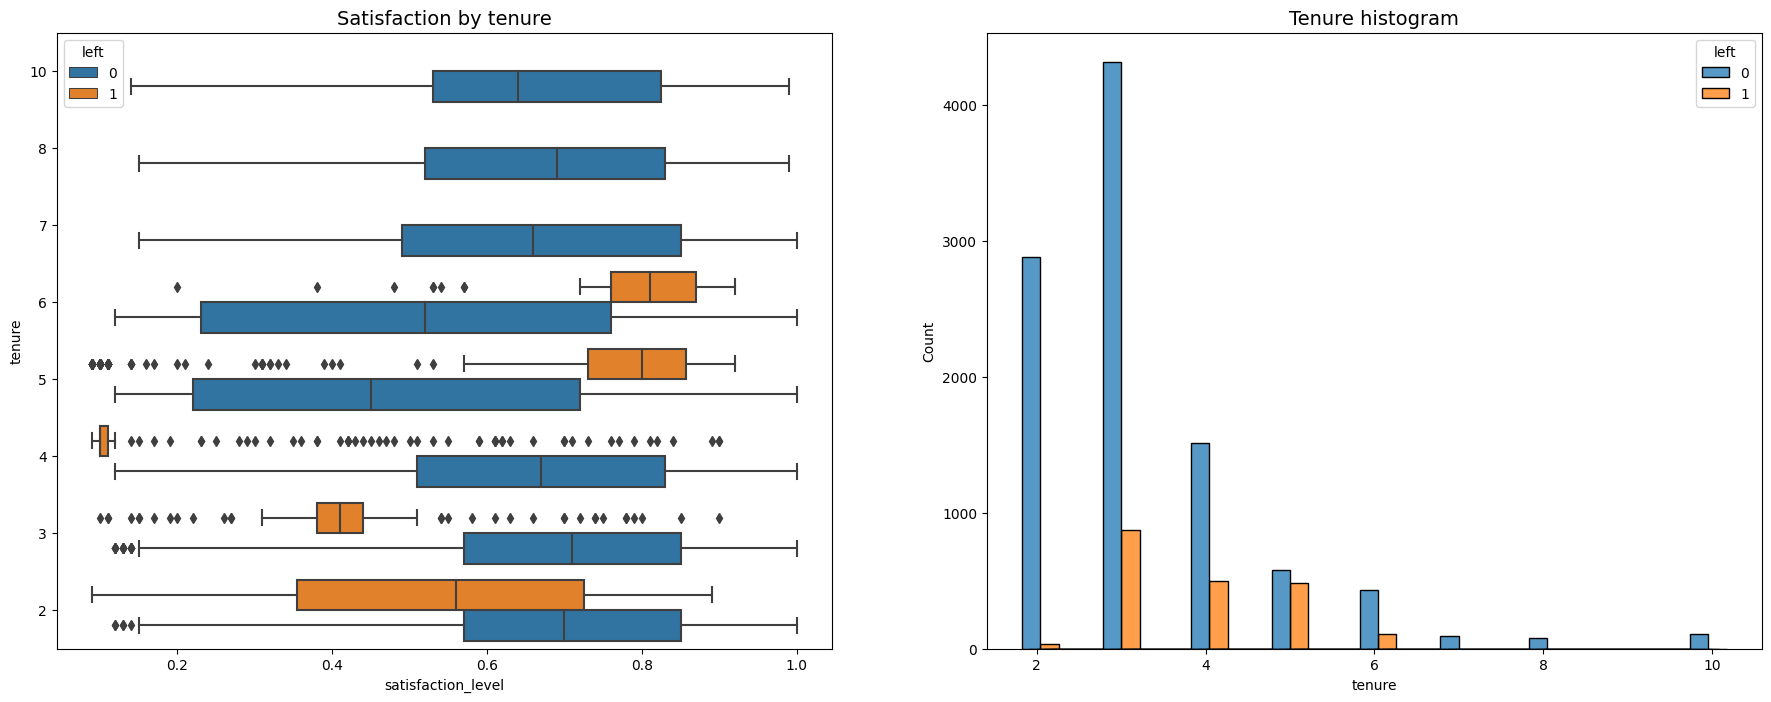

In [19]:
# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Boxplot showing distributions of `satisfaction_level` by tenure, comparing employees who stayed versus those who left
sns.boxplot(data=df1, x='satisfaction_level', y='tenure', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction by tenure', fontsize='14')

# Histogram showing distribution of `tenure`, comparing employees who stayed versus those who left
tenure_stay = df1[df1['left']==0]['tenure']
tenure_left = df1[df1['left']==1]['tenure']
sns.histplot(data=df1, x='tenure', hue='left', multiple='dodge', shrink=5, ax=ax[1])
ax[1].set_title('Tenure histogram', fontsize='14')

plt.show();

There are many observations you could make from this plot.

Employees who left fall into two general categories: dissatisfied employees with shorter tenures and very satisfied employees with medium-length tenures.
Four-year employees who left seem to have an unusually low satisfaction level. It's worth investigating changes to company policy that might have affected people specifically at the four-year mark, if possible.
The longest-tenured employees didn't leave. Their satisfaction levels aligned with those of newer employees who stayed.
The histogram shows that there are relatively few longer-tenured employees. It's possible that they're the higher-ranking, higher-paid employees.
As the next step in analyzing the data, we could calculate the mean and median satisfaction scores of employees who left and those who didn't.

In [20]:
df1.groupby(['left'])['satisfaction_level'].agg([np.mean,np.median])

mean  median
left                  
0     0.667365    0.69
1     0.440271    0.41

As expected, the mean and median satisfaction scores of employees who left are lower than those of employees who stayed. Interestingly, among employees who stayed, the mean satisfaction score appears to be slightly below the median score. This indicates that satisfaction levels among those who stayed might be skewed to the left.

Next, we could examine salary levels for different tenures.

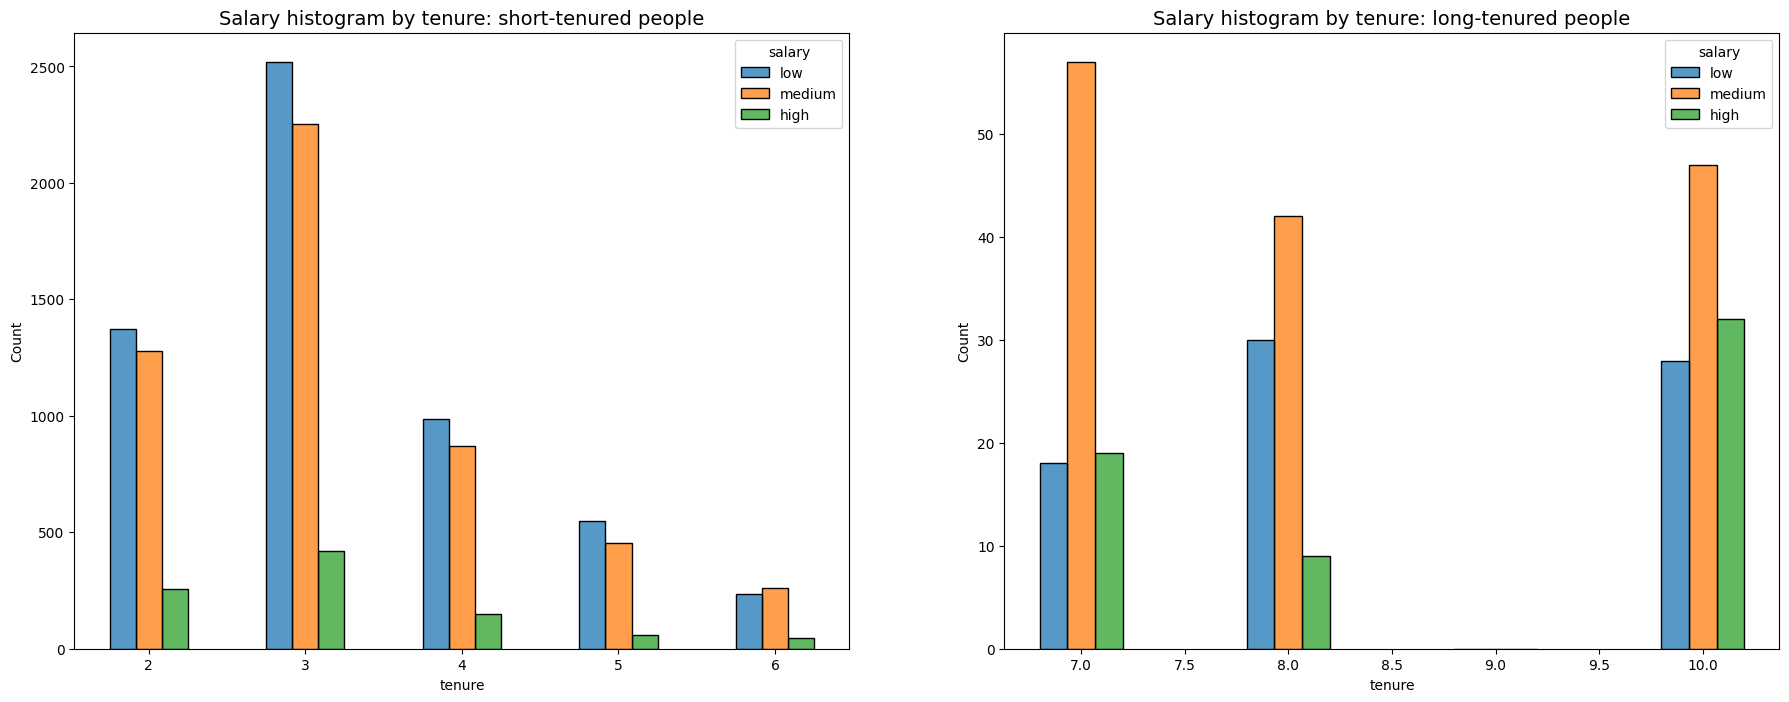

In [21]:


# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Define short-tenured employees
tenure_short = df1[df1['tenure'] < 7]

# Define long-tenured employees
tenure_long = df1[df1['tenure'] > 6]

# Plot short-tenured histogram
sns.histplot(data=tenure_short, x='tenure', hue='salary', discrete=1,
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.5, ax=ax[0])
ax[0].set_title('Salary histogram by tenure: short-tenured people', fontsize='14')

# Plot long-tenured histogram
sns.histplot(data=tenure_long, x='tenure', hue='salary', discrete=1,
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.4, ax=ax[1])
ax[1].set_title('Salary histogram by tenure: long-tenured people', fontsize='14');

The plots above show that long-tenured employees were not disproportionately comprised of higher-paid employees.

Next, we could explore whether there's a correlation between working long hours and receiving high evaluation scores. You could create a scatterplot of average_monthly_hours versus last_evaluation.


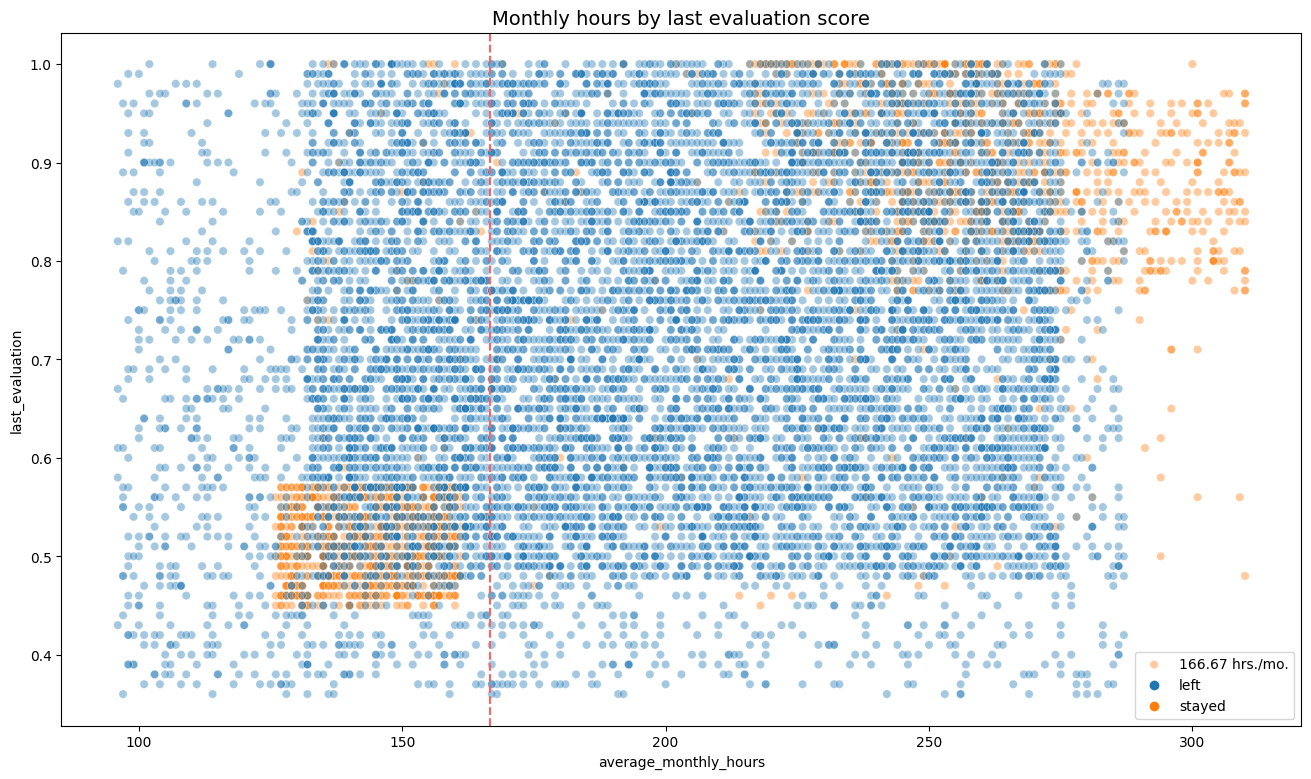

In [22]:
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df1, x='average_monthly_hours', y='last_evaluation', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14');

The following observations can be made from the scatterplot above:

* The scatterplot indicates two groups of employees who left: overworked employees who performed very well and employees who worked slightly under the nominal monthly average of 166.67 hours with lower evaluation scores.
* There seems to be a correlation between hours worked and evaluation score.
* There isn't a high percentage of employees in the upper left quadrant of this plot; but working long hours doesn't guarantee a good evaluation score.
* Most of the employees in this company work well over 167 hours per month.


Next, we could examine whether employees who worked very long hours were promoted in the last five years.

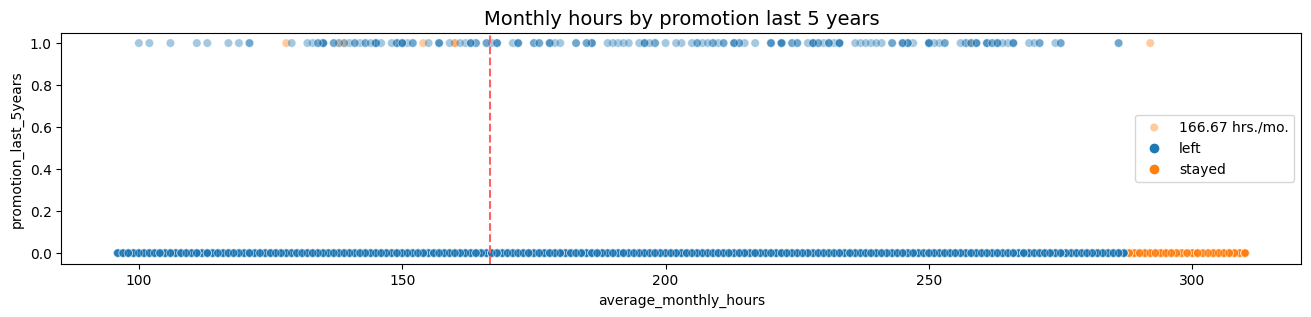

In [23]:
plt.figure(figsize=(16, 3))
sns.scatterplot(data=df1, x='average_monthly_hours', y='promotion_last_5years', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by promotion last 5 years', fontsize='14');

The plot above shows the following:

* very few employees who were promoted in the last five years left
* very few employees who worked the most hours were promoted
* all of the employees who left were working the longest hours


Next, you could inspect how the employees who left are distributed across departments.

In [24]:
df1["department"].value_counts()

sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: department, dtype: int64

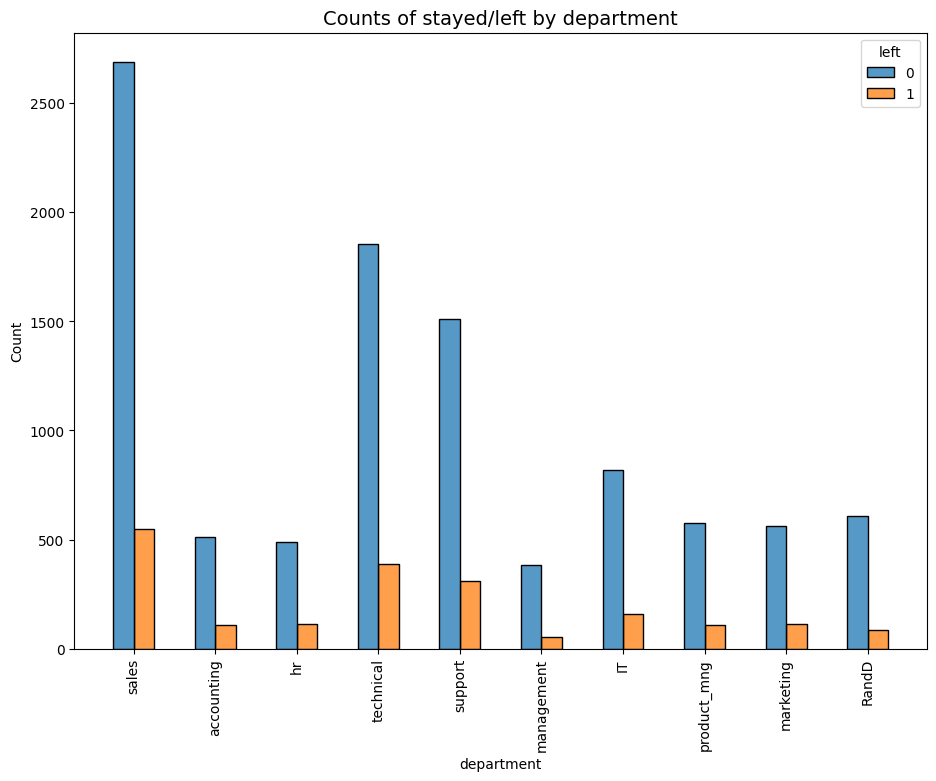

In [25]:
# I create stacked histogram to compare department distribution of employees who left to that of employees who didn't
plt.figure(figsize=(11,8))
sns.histplot(data=df1, x='department', hue='left', discrete=1,
             hue_order=[0, 1], multiple='dodge', shrink=.5)
plt.xticks(rotation='vertical')
plt.title('Counts of stayed/left by department', fontsize=14);

There doesn't seem to be any department that differs significantly in its proportion of employees who left to those who stayed.

Lastly, we could check for strong correlations between variables in the data.

<ipython-input-26-9faa69ae0039>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df0.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))


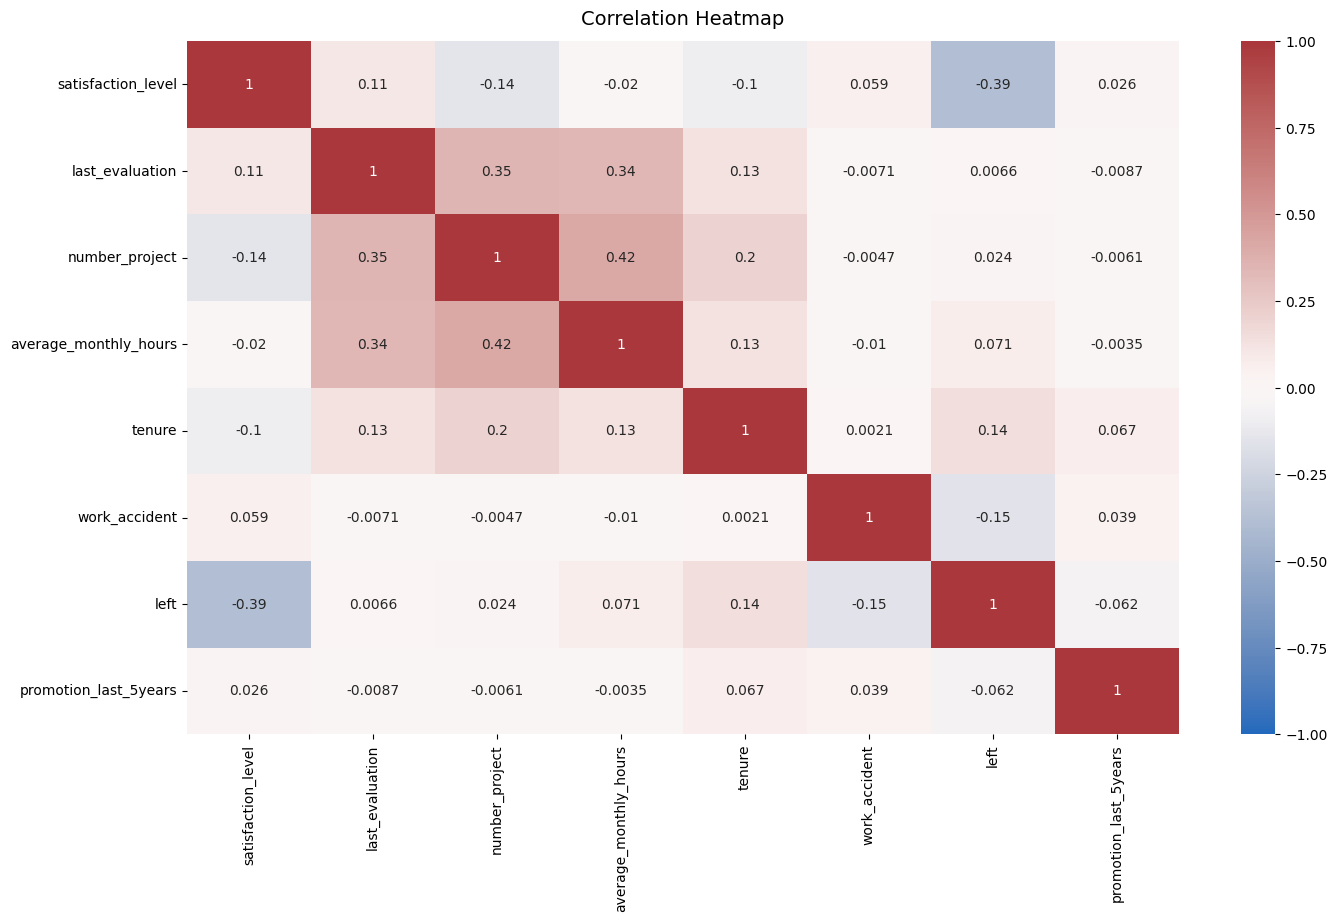

In [26]:
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(df0.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);



The correlation heatmap confirms that the number of projects, monthly hours, and evaluation scores all have some positive correlation with each other, and whether an employee leaves is negatively correlated with their satisfaction level.

#**Model building and Results/Evaluation**

* Identify the type of prediction task.

Our goal is to predict whether an employee leaves the company, which is a categorical outcome variable. So this task involves binary classification, since the outcome variable left can be either 1 (indicating employee left) or 0 (indicating employee didn't leave).

* Identify the types of models most appropriate for this task.

Since the variable we want to predict (whether an employee leaves the company) is categorical, we could either build a Logistic Regression model, or a Tree-based Machine Learning model.

So we could proceed with one of the two following approaches. Or, if you'd like, you could implement both and determine how they compare.

#**Logistic regression**

In [27]:
# One-hot encode the categorical variables as needed and save resulting dataframe in a new variable
df_enc = pd.get_dummies(df1, prefix=['salary', 'dept'], columns = ['salary', 'department'], drop_first=False)

# Display the new dataframe
df_enc.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  left  promotion_last_5years  salary_high  \
0       3              0     1                      0            0   
1       6              0     1                      0            0   
2       4              0     1                      0            0   
3       5              0     1                      0            0   
4       3              0     1                      0            0   

   salary_low  salary_medium  dept_IT  dept_RandD  dept_accounting  dept_hr  \
0           1              0        0           0                0        0   
1           0              1        0           0                0        0   
2           0              1        0           0                0        0   
3           1              0        0           0                0        0   
4           1              0        0           0                0        0   

   dept_management  dept_marketing  dept_product_mng  dept_sales  \
0                0               0                 0           1   
1                0               0                 0           1   
2                0               0                 0           1   
3                0               0                 0           1   
4                0               0                 0           1   

   dept_support  dept_technical  
0             0               0  
1             0               0  
2             0               0  
3             0               0  
4             0               0

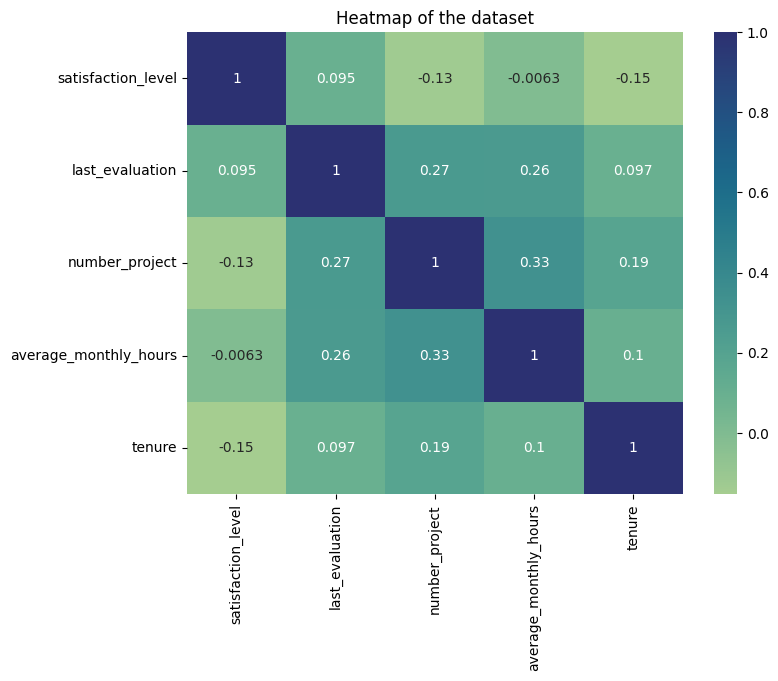

In [28]:
# Heatmap to visualize how correlated variables are
plt.figure(figsize=(8, 6))
sns.heatmap(df_enc[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']].corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

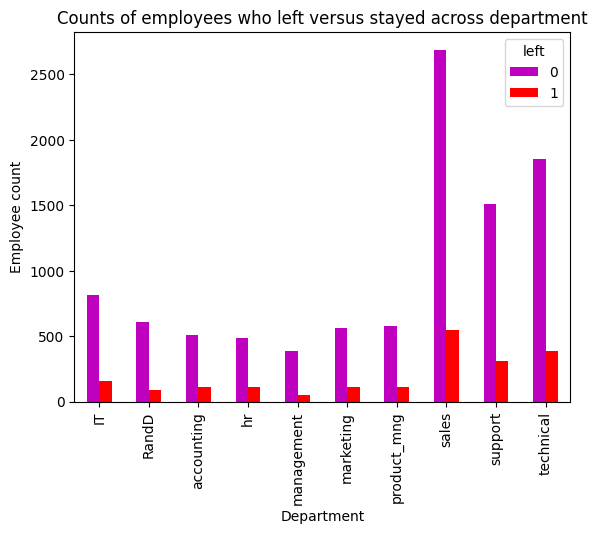

In [29]:
# Stacked bart plot to visualize number of employees across department, comparing those who left with those who didn't
# In the legend, 0 (purple color) represents employees who did not leave, 1 (red color) represents employees who left
pd.crosstab(df1["department"], df1["left"]).plot(kind ='bar',color='mr')
plt.title('Counts of employees who left versus stayed across department')
plt.ylabel('Employee count')
plt.xlabel('Department')
plt.show()

In [30]:
# Select rows without outliers in `tenure` and save resulting dataframe in a new variable
df_logreg = df_enc[(df_enc['tenure'] >= lower_limit) & (df_enc['tenure'] <= upper_limit)]

# Display first few rows of new dataframe
df_logreg.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   
5                0.41             0.50               2                    153   

   tenure  work_accident  left  promotion_last_5years  salary_high  \
0       3              0     1                      0            0   
2       4              0     1                      0            0   
3       5              0     1                      0            0   
4       3              0     1                      0            0   
5       3              0     1                      0            0   

   salary_low  salary_medium  dept_IT  dept_RandD  dept_accounting  dept_hr  \
0           1              0        0           0                0        0   
2           0              1        0           0                0        0   
3           1              0        0           0                0        0   
4           1              0        0           0                0        0   
5           1              0        0           0                0        0   

   dept_management  dept_marketing  dept_product_mng  dept_sales  \
0                0               0                 0           1   
2                0               0                 0           1   
3                0               0                 0           1   
4                0               0                 0           1   
5                0               0                 0           1   

   dept_support  dept_technical  
0             0               0  
2             0               0  
3             0               0  
4             0               0  
5             0               0

In [31]:
y = df_logreg['left']


y.head()

0    1
2    1
3    1
4    1
5    1
Name: left, dtype: int64

In [32]:
# The features you want to use in your model
X = df_logreg[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure', 'work_accident', 'promotion_last_5years', 'salary_high', 'salary_low', 'salary_medium' , 'dept_IT', 'dept_RandD', 'dept_accounting', 'dept_hr', 'dept_management', 'dept_marketing', 'dept_product_mng', 'dept_sales', 'dept_support', 'dept_technical']]

# Display the first few rows of the selected features
X.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   
5                0.41             0.50               2                    153   

   tenure  work_accident  promotion_last_5years  salary_high  salary_low  \
0       3              0                      0            0           1   
2       4              0                      0            0           0   
3       5              0                      0            0           1   
4       3              0                      0            0           1   
5       3              0                      0            0           1   

   salary_medium  dept_IT  dept_RandD  dept_accounting  dept_hr  \
0              0        0           0                0        0   
2              1        0           0                0        0   
3              0        0           0                0        0   
4              0        0           0                0        0   
5              0        0           0                0        0   

   dept_management  dept_marketing  dept_product_mng  dept_sales  \
0                0               0                 0           1   
2                0               0                 0           1   
3                0               0                 0           1   
4                0               0                 0           1   
5                0               0                 0           1   

   dept_support  dept_technical  
0             0               0  
2             0               0  
3             0               0  
4             0               0  
5             0               0

In [33]:
# Split the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Construct a logistic regression model and fit it to the training dataset
log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)

# Use the logistic regression model to get predictions on the test set
y_pred = log_clf.predict(X_test)

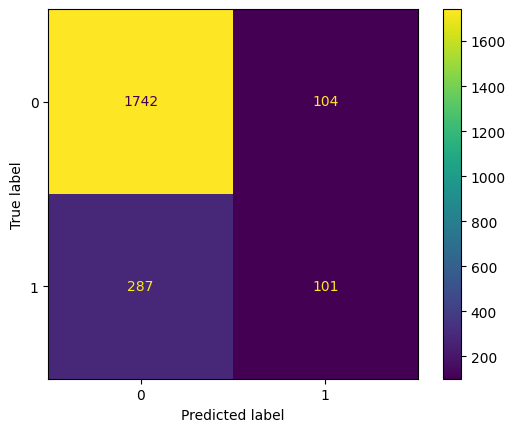

In [34]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# Confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

The upper-left quadrant displays the number of true negatives. The upper-right quadrant displays the number of false positives. The bottom-left quadrant displays the number of false negatives. The bottom-right quadrant displays the number of true positives.

True negatives: The number of people who did not leave that the model accurately predicted did not leave.

False positives: The number of people who did not leave the model inaccurately predicted as leaving.

False negatives: The number of people who left that the model inaccurately predicted did not leave

True positives: The number of people who left the model accurately predicted as leaving



In [35]:
df_logreg['left'].value_counts(normalize=True)

0    0.831468
1    0.168532
Name: left, dtype: float64

There is an approximately 83%-17% split. So the data is not perfectly balanced, but it is not too imbalanced

In [36]:
# Classification report for logistic regression model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.94      0.90      1846
    Predicted would leave       0.49      0.26      0.34       388

                 accuracy                           0.82      2234
                macro avg       0.68      0.60      0.62      2234
             weighted avg       0.80      0.82      0.80      2234



The classification report above shows that the logistic regression model achieved a precision of 80%, recall of 83%, f1-score of 80% (all weighted averages), and accuracy of 83%.

# **Tree-based Model**

In [37]:
# Encode categorical variables
df2 = pd.get_dummies(df1)
# Isolate the outcome variable
y = df2['left']

# Display the first few rows of `y`
y.head()

0    1
1    1
2    1
3    1
4    1
Name: left, dtype: int64

In [38]:
# Select the features
X = df2.drop('left', axis=1)

# Display the first few rows of `X`
X.head()

satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0                0.38             0.53               2                    157   
1                0.80             0.86               5                    262   
2                0.11             0.88               7                    272   
3                0.72             0.87               5                    223   
4                0.37             0.52               2                    159   

   tenure  work_accident  promotion_last_5years  department_IT  \
0       3              0                      0              0   
1       6              0                      0              0   
2       4              0                      0              0   
3       5              0                      0              0   
4       3              0                      0              0   

   department_RandD  department_accounting  department_hr  \
0                 0                      0              0   
1                 0                      0              0   
2                 0                      0              0   
3                 0                      0              0   
4                 0                      0              0   

   department_management  department_marketing  department_product_mng  \
0                      0                     0                       0   
1                      0                     0                       0   
2                      0                     0                       0   
3                      0                     0                       0   
4                      0                     0                       0   

   department_sales  department_support  department_technical  salary_high  \
0                 1                   0                     0            0   
1                 1                   0                     0            0   
2                 1                   0                     0            0   
3                 1                   0                     0            0   
4                 1                   0                     0            0   

   salary_low  salary_medium  
0           1              0  
1           0              1  
2           0              1  
3           1              0  
4           1              0

In [39]:
# Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

# Train & validate data
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=0)

In [40]:
# Instantiate model
tree = DecisionTreeClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [41]:
%%time
tree1.fit(X_tr, y_tr)

CPU times: user 4.4 s, sys: 11.5 ms, total: 4.41 s
Wall time: 4.47 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'recall', 'precision', 'accuracy', 'roc_auc', 'f1'})

In [42]:
# Check best parameters
tree1.best_params_

{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [43]:
# Check best AUC score on CV
tree1.best_score_

0.9703634179699269

In [44]:
def make_results(model_name:str, model_object, metric:str):


    # Dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                 'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Table of results
    table = pd.DataFrame()
    table = table.append({'Model': model_name,
                        'AUC': auc,
                        'Precision': precision,
                        'Recall': recall,
                        'F1': f1,
                        'Accuracy': accuracy,
                        },
                        ignore_index=True
                       )

    return table

In [45]:
# Get all CV scores
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results

<ipython-input-44-cfb0847431ce>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name,


Model       AUC  Precision    Recall        F1  Accuracy
0  decision tree cv  0.970363   0.922167  0.921337  0.921719  0.974007

**Random forest - Round 1**

In [46]:
# Instantiate model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None],
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [47]:
%%time
rf1.fit(X_tr, y_tr) # --> Wall time: ~22min

CPU times: user 26min 2s, sys: 4.01 s, total: 26min 6s
Wall time: 26min 37s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'recall', 'precision', 'accuracy', 'roc_auc', 'f1'})

In [57]:
# Path to the folder where you want to save the model
path = '/content/HR_comma_sep.csv'

In [58]:
def write_pickle(path, model_object, save_as:str):


    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [59]:
def read_pickle(path, saved_model_name:str):


    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

In [60]:
# Write pickle
write_pickle(path, rf1, 'hr_rf1')

In [61]:
# Read pickle
rf1 = read_pickle(path, 'hr_rf1')

In [62]:
# Check best AUC score on CV
rf1.best_score_

0.9795790967836983

In [63]:
# Check best params
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 500}

In [64]:
# Get all CV scores
rf1_cv_results = make_results('random forest cv', rf1, 'auc')
print(tree1_cv_results)
print(rf1_cv_results)

              Model       AUC  Precision    Recall        F1  Accuracy
0  decision tree cv  0.970363   0.922167  0.921337  0.921719  0.974007
              Model       AUC  Precision    Recall        F1  Accuracy
0  random forest cv  0.979579   0.943576  0.923021  0.933145  0.978037


<ipython-input-44-cfb0847431ce>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name,


The evaluation scores of the random forest model are better than those of the decision tree model, with the exception of recall (the recall score of the random forest model is approximately 0.008 lower, which is a negligible amount). This indicates that the random forest model mostly outperforms the decision tree model.

Next, we can evaluate these models on the validation set.

Now I define a function that gets all the scores from a model's predictions.



In [65]:
def get_scores(model_name:str, model, X_test_data, y_test_data):

    preds = model.best_estimator_.predict(X_test_data)

    auc = round(roc_auc_score(y_test_data, preds), 3)
    accuracy = round(accuracy_score(y_test_data, preds), 3)
    precision = round(precision_score(y_test_data, preds), 3)
    recall = round(recall_score(y_test_data, preds), 3)
    f1 = round(f1_score(y_test_data, preds), 3)

    table = pd.DataFrame({'model': [model_name],
                        'AUC': [auc],
                        'precision': [precision],
                        'recall': [recall],
                        'f1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

In [66]:
# Get the results on validation set for both models
tree1_val_results = get_scores('decision tree1 val', tree1, X_val, y_val)
rf1_val_results = get_scores('random forest1 val', rf1, X_val, y_val)

# Concatenate validation scores into table
all_val_results1 = [tree1_val_results, rf1_val_results]
all_val_results1 = pd.concat(all_val_results1).sort_values(by='AUC', ascending=False)
all_val_results1

model    AUC  precision  recall     f1  accuracy
0  random forest1 val  0.954      0.955   0.917  0.936     0.979
0  decision tree1 val  0.952      0.924   0.920  0.922     0.974

On the validation set, the random forest model outperforms the decision tree model across most metrics.

Now use the best performing model to predict on the test set.

In [67]:
# Get predictions on test data
rf1_test_scores = get_scores('random forest1 test', rf1, X_test, y_test)
rf1_test_scores

model    AUC  precision  recall     f1  accuracy
0  random forest1 test  0.955      0.961   0.917  0.938      0.98

The test scores are very similar to the validation scores, which is good. This appears to be a strong model


# **Feature Engineering**




In [68]:
# Drop `satisfaction_level` and save resulting dataframe in new variable
df3 = df1.drop('satisfaction_level', axis=1)

# Display first few rows of new dataframe
df3.head()

last_evaluation  number_project  average_monthly_hours  tenure  \
0             0.53               2                    157       3   
1             0.86               5                    262       6   
2             0.88               7                    272       4   
3             0.87               5                    223       5   
4             0.52               2                    159       3   

   work_accident  left  promotion_last_5years department  salary  
0              0     1                      0      sales     low  
1              0     1                      0      sales  medium  
2              0     1                      0      sales  medium  
3              0     1                      0      sales     low  
4              0     1                      0      sales     low

In [69]:
# `overworked` column. For now, it's identical to average monthly hours.
df3['overworked'] = df3['average_monthly_hours']

# Inspect max and min average monthly hours values
print('Max hours:', df3['overworked'].max())
print('Min hours:', df3['overworked'].min())

Max hours: 310
Min hours: 96


166.67 is approximately the average number of monthly hours for someone who works 50 weeks per year, 5 days per week, 8 hours per day.

To make the overworked column binary, I reassign the column using a boolean mask.

In [70]:
# Define `overworked` as working > 175 hrs/week
df3['overworked'] = (df3['overworked'] > 175).astype(int)

# Display first few rows of new column
df3['overworked'].head()

0    0
1    1
2    1
3    1
4    0
Name: overworked, dtype: int64

In [71]:
# Drop the `average_monthly_hours` column
df3 = df3.drop('average_monthly_hours', axis=1)

# Display first few rows of resulting dataframe
df3.head()


last_evaluation  number_project  tenure  work_accident  left  \
0             0.53               2       3              0     1   
1             0.86               5       6              0     1   
2             0.88               7       4              0     1   
3             0.87               5       5              0     1   
4             0.52               2       3              0     1   

   promotion_last_5years department  salary  overworked  
0                      0      sales     low           0  
1                      0      sales  medium           1  
2                      0      sales  medium           1  
3                      0      sales     low           1  
4                      0      sales     low           0

In [72]:
# One-hot encode the categorical variables as needed and save resulting dataframe in a new variable
df4 = pd.get_dummies(df3)

# Display the new dataframe
df4.head()

last_evaluation  number_project  tenure  work_accident  left  \
0             0.53               2       3              0     1   
1             0.86               5       6              0     1   
2             0.88               7       4              0     1   
3             0.87               5       5              0     1   
4             0.52               2       3              0     1   

   promotion_last_5years  overworked  department_IT  department_RandD  \
0                      0           0              0                 0   
1                      0           1              0                 0   
2                      0           1              0                 0   
3                      0           1              0                 0   
4                      0           0              0                 0   

   department_accounting  department_hr  department_management  \
0                      0              0                      0   
1                      0              0                      0   
2                      0              0                      0   
3                      0              0                      0   
4                      0              0                      0   

   department_marketing  department_product_mng  department_sales  \
0                     0                       0                 1   
1                     0                       0                 1   
2                     0                       0                 1   
3                     0                       0                 1   
4                     0                       0                 1   

   department_support  department_technical  salary_high  salary_low  \
0                   0                     0            0           1   
1                   0                     0            0           0   
2                   0                     0            0           0   
3                   0                     0            0           1   
4                   0                     0            0           1   

   salary_medium  
0              0  
1              1  
2              1  
3              0  
4              0

In [73]:
# Isolate the outcome variable
y = df4['left']

# Display the first few rows of `y`
y.head()

0    1
1    1
2    1
3    1
4    1
Name: left, dtype: int64

In [74]:
# Select the features
X = df4.drop('left', axis=1)

# Display the first few rows of `X`
X.head()

last_evaluation  number_project  tenure  work_accident  \
0             0.53               2       3              0   
1             0.86               5       6              0   
2             0.88               7       4              0   
3             0.87               5       5              0   
4             0.52               2       3              0   

   promotion_last_5years  overworked  department_IT  department_RandD  \
0                      0           0              0                 0   
1                      0           1              0                 0   
2                      0           1              0                 0   
3                      0           1              0                 0   
4                      0           0              0                 0   

   department_accounting  department_hr  department_management  \
0                      0              0                      0   
1                      0              0                      0   
2                      0              0                      0   
3                      0              0                      0   
4                      0              0                      0   

   department_marketing  department_product_mng  department_sales  \
0                     0                       0                 1   
1                     0                       0                 1   
2                     0                       0                 1   
3                     0                       0                 1   
4                     0                       0                 1   

   department_support  department_technical  salary_high  salary_low  \
0                   0                     0            0           1   
1                   0                     0            0           0   
2                   0                     0            0           0   
3                   0                     0            0           1   
4                   0                     0            0           1   

   salary_medium  
0              0  
1              1  
2              1  
3              0  
4              0

In [75]:
# Create test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

# Create train & validate data
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=0)

# **Decision tree - Round 2**

In [76]:

tree = DecisionTreeClassifier(random_state=0)

cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}


tree2 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [77]:
%%time
tree2.fit(X_tr, y_tr)

CPU times: user 4.53 s, sys: 9.95 ms, total: 4.54 s
Wall time: 4.69 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'recall', 'precision', 'accuracy', 'roc_auc', 'f1'})

In [78]:
# Check best params
tree2.best_params_

# Check best AUC score on CV
tree2.best_score_

# Get all CV scores
tree2_cv_results = make_results('decision tree2 cv', tree2, 'auc')
tree2_cv_results

<ipython-input-44-cfb0847431ce>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name,


Model       AUC  Precision    Recall        F1  Accuracy
0  decision tree2 cv  0.953483   0.864826  0.902098  0.883024  0.960245

# **Random forest - Round 2**

In [79]:
# Instantiate model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None],
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiate GridSearch
rf2 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [80]:
%%time
rf2.fit(X_tr, y_tr) # --> Wall time: 17min 5s

CPU times: user 20min 34s, sys: 3.61 s, total: 20min 37s
Wall time: 21min 33s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'recall', 'precision', 'accuracy', 'roc_auc', 'f1'})

In [81]:
# Write pickle
write_pickle(path, rf2, 'hr_rf2')

In [82]:
# Read in pickle
rf2 = read_pickle(path, 'hr_rf2')

In [83]:
# Check best params
rf2.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 300}

In [84]:
# Check best AUC score on CV
rf2.best_score_

0.9656664586139387

In [85]:
# Get all CV scores
rf2_cv_results = make_results('random forest2 cv', rf2, 'auc')
print(tree2_cv_results)
print(rf2_cv_results)

               Model       AUC  Precision    Recall        F1  Accuracy
0  decision tree2 cv  0.953483   0.864826  0.902098  0.883024  0.960245
               Model       AUC  Precision    Recall        F1  Accuracy
0  random forest2 cv  0.965666   0.909473  0.879506  0.894049  0.965388


<ipython-input-44-cfb0847431ce>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name,


In [86]:
# Collect validation scores
tree2_val_results = get_scores('decision tree2 val', tree2, X_val, y_val)
rf2_val_results = get_scores('random forest2 val', rf2, X_val, y_val)

# Concatenate validation scores into table
all_val_results2 = [tree2_val_results, rf2_val_results]
all_val_results2 = pd.concat(all_val_results2).sort_values(by='AUC', ascending=False)
all_val_results2

model    AUC  precision  recall     f1  accuracy
0  decision tree2 val  0.942      0.883   0.907  0.895     0.965
0  random forest2 val  0.933      0.905   0.884  0.895     0.965

In [87]:
# Get predictions on test data
rf2_test_scores = get_scores('random forest2 test', rf2, X_test, y_test)
rf2_test_scores

model    AUC  precision  recall     f1  accuracy
0  random forest2 test  0.935      0.898   0.889  0.894     0.965

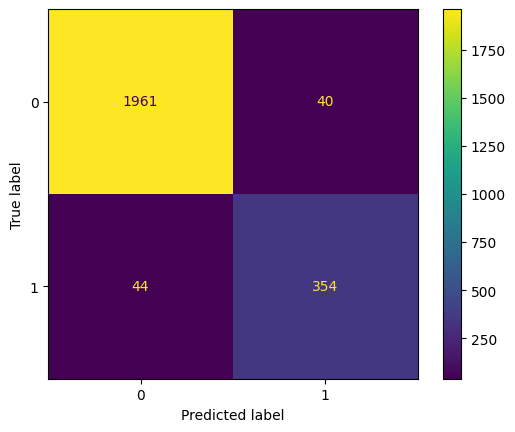

In [88]:
# Generate array of values for confusion matrix
preds = rf2.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf2.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf2.classes_)
disp.plot();

The model predicts more false positives than false negatives, which means that some employees may be identified as at risk of quitting or getting fired, when that's actually not the case. who are not actually at risk of doing so. But this is still a strong model.

For exploratory purpose, I want to inspect the splits of the decision tree model and the most important features in the random forest model.

# Decision tree splits

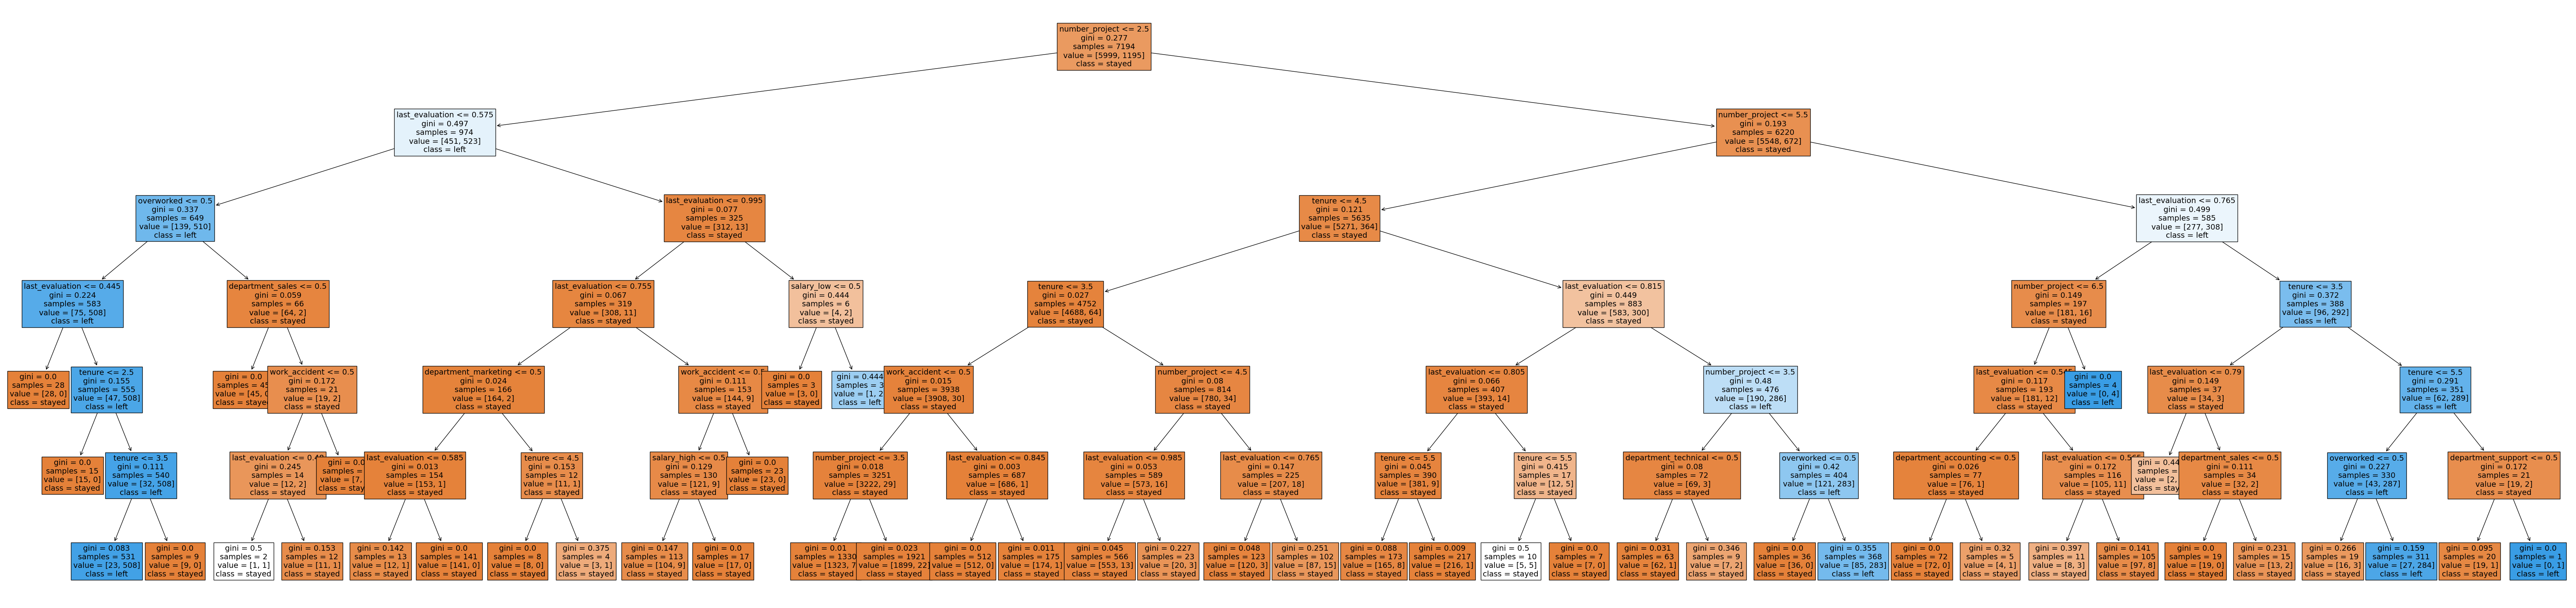

In [89]:
plt.figure(figsize=(85,20))
plot_tree(tree2.best_estimator_, max_depth=6, fontsize=14, feature_names=X.columns,
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

In [90]:
#tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, columns=X.columns)
tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, columns=['gini_importance'], index=X.columns)
tree2_importances = tree2_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
tree2_importances = tree2_importances[tree2_importances['gini_importance'] != 0]
tree2_importances

gini_importance
number_project                0.381767
last_evaluation               0.353482
tenure                        0.169771
overworked                    0.091517
department_support            0.001099
salary_low                    0.000853
department_technical          0.000429
department_sales              0.000357
work_accident                 0.000282
department_accounting         0.000239
salary_high                   0.000120
department_marketing          0.000084

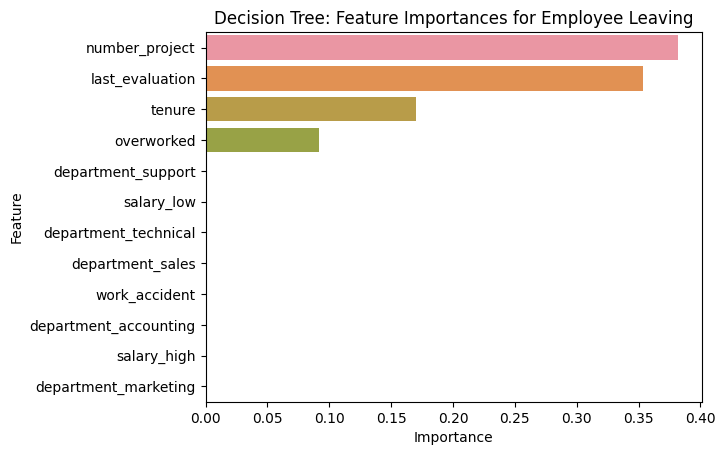

In [91]:
#barplot to visualize the decision tree feature importances.

sns.barplot(data=tree2_importances, x="gini_importance", y=tree2_importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

# Random forest feature importance

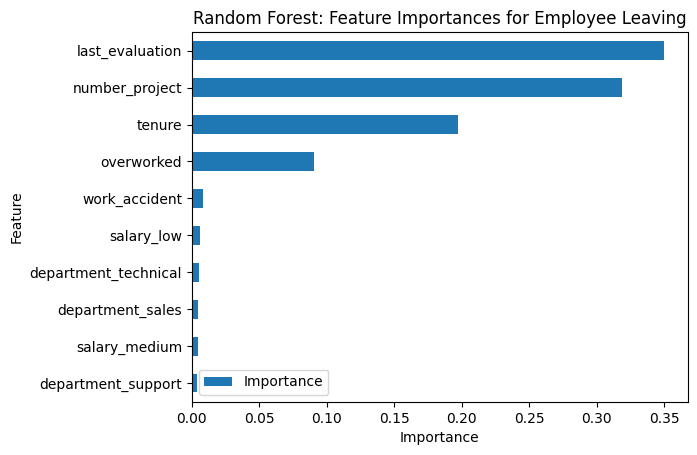

In [92]:
# Get feature importances
feat_impt = rf2.best_estimator_.feature_importances_

# Get indices of top 10 features
ind = np.argpartition(rf2.best_estimator_.feature_importances_, -10)[-10:]

# Get column labels of top 10 features
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

#Summary of model results

* Logistic Regression

The logistic regression model achieved precision of 80%, recall of 83%, f1-score of 80% (all weighted averages), and accuracy of 83%, on the test set.

* Tree-based Machine Learning

After conducting feature engineering, the decision tree model achieved AUC of 94.3%, precision of 86.5%, recall of 91.5%, f1-score of 88.9%, and accuracy of 96.2%, on the test set. The random forest modelslightly outperformed the decision tree model.



# Conclusion, Recommendations, Next Steps
The models and the feature importances extracted from the models confirm that employees at the company are overworked.

To retain employees, the following recommendations could be presented to the stakeholders:

* Cap the number of projects that employees can work on.
* Consider promoting employees who have been with the company for atleast four years, or conduct further investigation about why four-year tenured employees are so dissatisfied.
* Either reward employees for working longer hours, or don't require them to do so.
* If employees aren't familiar with the company's overtime pay policies, inform them about this. If the expectations around workload and time off aren't explicit, make them clear.
* Hold company-wide and within-team discussions to understand and address the company work culture, across the board and in specific contexts.
* High evaluation scores should not be reserved for employees who work 200+ hours per month. Consider a proportionate scale for rewarding employees who contribute more/put in more effort.